In [2]:
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
import os
import time

In [3]:
train_df = pd.read_csv("data/kickstarter_train.csv")
test_df = pd.read_csv("data/kickstarter_test.csv")

print(train_df.shape)
print(test_df.shape)

(24756, 579)
(4369, 579)


<h1>Get to the correct data format</h1>

In [5]:
X_train, y_train = train_df.drop('state', axis=1), train_df['state']
X_test, y_test = test_df.drop('state', axis=1), test_df['state']

In [6]:
X_train.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

<h3>Training using Logisitic Regression Model</h3>

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(24756, 578)
(24756,)
(4369, 578)
(4369,)


In [12]:
LRModel = LogisticRegression(max_iter=25000)
LRModel.fit(X_train, y_train)
# Train set
LRModel_train_score = LRModel.score(X_train, y_train)
print('Train Set Accuracy Score: ', LRModel_train_score)
pred = LRModel.predict(X_train)
print("Train Set Confusion Matrix \n", confusion_matrix(y_train, pred))
print("Train Set",classification_report(y_train, pred))

auc_pred = LRModel.predict_proba(X_train)[:,1]
area_under_curve_train = metrics.roc_auc_score(y_train, auc_pred)
print("Area Under Curve:", area_under_curve_train)

Train Set Accuracy Score:  0.8413717886572952
Train Set Confusion Matrix 
 [[ 4888  2386]
 [ 1541 15941]]
Train Set               precision    recall  f1-score   support

           0       0.76      0.67      0.71      7274
           1       0.87      0.91      0.89     17482

    accuracy                           0.84     24756
   macro avg       0.82      0.79      0.80     24756
weighted avg       0.84      0.84      0.84     24756

Area Under Curve: 0.9042336314689147


In [13]:
#Test Set
LRModel_test_score = LRModel.score(X_test, y_test)
print('Test Set Accuracy Score: ', LRModel_test_score)
test_pred = LRModel.predict(X_test)
print("Test Set Confusion Matrix \n", confusion_matrix(y_test, test_pred))
print("Test Set",classification_report(y_test, test_pred))


auc_pred_test = LRModel.predict_proba(X_test)[:,1]
area_under_curve_test = metrics.roc_auc_score(y_test, auc_pred_test)
print("Area Under Curve:", area_under_curve_test)

Test Set Accuracy Score:  0.8450446326390478
Test Set Confusion Matrix 
 [[ 889  393]
 [ 284 2803]]
Test Set               precision    recall  f1-score   support

           0       0.76      0.69      0.72      1282
           1       0.88      0.91      0.89      3087

    accuracy                           0.85      4369
   macro avg       0.82      0.80      0.81      4369
weighted avg       0.84      0.85      0.84      4369

Area Under Curve: 0.9069898072890845


## Hyper parameter tuning

In [14]:
import warnings
warnings.filterwarnings("ignore")

#using repeatedStratifiedKfold 
model = LogisticRegression(max_iter=25000)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=999)
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = loguniform(1e-5, 100)

#define search
search = RandomizedSearchCV(
    model, 
    space, 
    n_iter=100, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=cv, 
    verbose=2,
    random_state=999)

# execute search
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

# Best Score: 0.8916403758883328
# Best Hyperparameters: {'C': 1.6008626393306489, 'penalty': 'l2', 'solver': 'lbfgs'}

Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Score: 0.8916403758883328
Best Hyperparameters: {'C': 1.6008626393306489, 'penalty': 'l2', 'solver': 'lbfgs'}


<h3> Testing with training model output </h3>

In [15]:
best_model = LogisticRegression(**result.best_params_, max_iter=25000)
best_model.fit(X_train, y_train)
# Train set
best_model_train_score = best_model.score(X_train, y_train)
print('Train Set Accuracy Score after tuning: ', best_model_train_score)
pred1 = best_model.predict(X_train)
print("Train Set Confusion Matrix \n", confusion_matrix(y_train, pred1))
print("Train Set",classification_report(y_train, pred1))

auc_pred1 = best_model.predict_proba(X_train)[:,1]
area_under_curve_train = metrics.roc_auc_score(y_train, auc_pred1)
print("Area Under Curve after tuning:", area_under_curve_train)

Train Set Accuracy Score after tuning:  0.8420584908709
Train Set Confusion Matrix 
 [[ 4905  2369]
 [ 1541 15941]]
Train Set               precision    recall  f1-score   support

           0       0.76      0.67      0.72      7274
           1       0.87      0.91      0.89     17482

    accuracy                           0.84     24756
   macro avg       0.82      0.79      0.80     24756
weighted avg       0.84      0.84      0.84     24756

Area Under Curve after tuning: 0.904630748365175


In [16]:
best_model_test_score = best_model.score(X_test, y_test)
print('Test Set Accuracy Score: ', best_model_test_score)
test_pred1 = best_model.predict(X_test)
print("Test Set Confusion Matrix \n", confusion_matrix(y_test, test_pred1))
print("Test Set \n",classification_report(y_test, test_pred1, digits=5))

auc_pred_test1 = best_model.predict_proba(X_test)[:,1]
area_under_curve_test = metrics.roc_auc_score(y_test, auc_pred_test1)
print("Area Under Curve:", area_under_curve_test)

Test Set Accuracy Score:  0.846646829938201
Test Set Confusion Matrix 
 [[ 892  390]
 [ 280 2807]]
Test Set 
               precision    recall  f1-score   support

           0    0.76109   0.69579   0.72698      1282
           1    0.87801   0.90930   0.89338      3087

    accuracy                        0.84665      4369
   macro avg    0.81955   0.80254   0.81018      4369
weighted avg    0.84370   0.84665   0.84455      4369

Area Under Curve: 0.9068652347648813


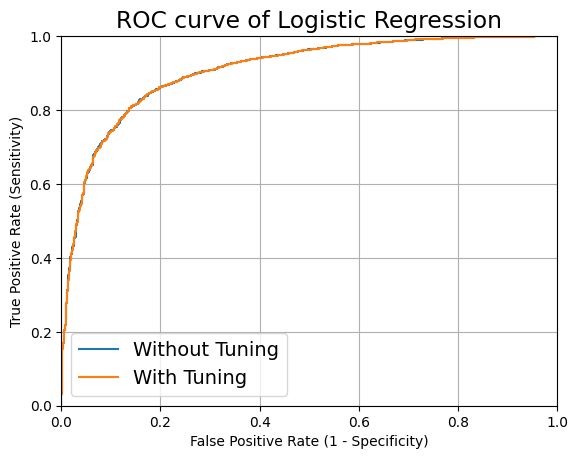

In [17]:
import matplotlib.pyplot as plt
test_predict = LRModel.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_predict)
plt.plot(fpr, tpr, label = "Without Tuning")
test_predict1 = best_model.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, test_predict1)
plt.plot(fpr1, tpr1, label = "With Tuning")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 14
plt.title('ROC curve of Logistic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid(True)

### Run Time

In [18]:
%%time
start_time = time.time()
model_time = LogisticRegression(**result.best_params_, max_iter=25000)
model_time.fit(X_train, y_train)
test_pred1 = model_time.predict(X_test)
print("Execution time: " + str((time.time() - start_time)) + ' s')

Execution time: 5.1522111892700195 s
Wall time: 5.15 s


### Feature Importance

In [19]:
imps = permutation_importance(model_time, X_test, y_test)
imps_sorted = imps.importances_mean.argsort()[::-1]

print(np.take(X_train.columns, imps_sorted[: 20]))

Index(['success_rate', 'staff_pick', 'reward_tiers', 'has_video',
       'funding_duration_in_days', 'description_story_41', 'x0_film & video',
       'x0_crafts', 'x0_comics', 'description_story_94',
       'description_story_word_count', 'rewards_41', 'description_risks_10',
       'description_story_49', 'rewards_80', 'description_96',
       'description_67', 'description_story_5', 'x0_publishing', 'x0_food'],
      dtype='object')
